# Load Packages

In [1]:
import sys
sys.path.append('..')

In [2]:
from fracdiff import fracdiff
import numpy as np
import scipy.special

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#!pip install memory_profiler
import memory_profiler
%load_ext memory_profiler

# Load Demo Data

In [5]:
with np.load('data/demo1.npz') as data:
    t = data['t']
    px = data['px']

In [6]:
x = px[:, 0]

In [7]:
del t, px

# Modeling

## (a) First Order Differentiation
Let $x_t$ a time series, 
$t\in\mathbb{N}$ the time step,
$\Delta^1$ the difference operator for first order $d=1$

$$
(\Delta^1 x)_t = x_t - x_{t-1}
$$


Example

In [8]:
z = x[1:] - x[:-1]
z

array([-2.2 ,  0.91, -1.93, ..., -1.56,  0.67,  0.  ])

Wrap it into a function

In [9]:
def firstdiff(x: np.ndarray) -> np.ndarray:
    z = np.empty(shape=x.shape)
    z[0] = np.nan
    z[1:] = x[1:] - x[:-1]
    return z

In [10]:
%time z = firstdiff(x)
print(z[:10])

CPU times: user 69 µs, sys: 20 µs, total: 89 µs
Wall time: 83 µs
[  nan -2.2   0.91 -1.93 -0.3   1.17  1.87  0.74 -0.46  0.14]


## (b) Integral Differentiation
Let $x_t$ a time series, 
$t\in\mathbb{N}$ the time step,
$\Delta^d$ the difference operator of integral order $d\in\mathbb{N}^+$

$$
(\Delta^d x)_t = \sum_{k=0}^d (-1)^k {d\choose k} x_{t-k}
$$


Example with `d=1`

In [11]:
# generate weights
d = 1
w = np.empty((d+1,))
for k in range(d+1):
    w[k] = np.power(-1, k) * scipy.special.binom(d, k)

print(w)

[ 1. -1.]


In [12]:
# apply weights
z = w[0] * x
z[:d] = np.nan
for k in range(1, d+1):
    z[k:] += w[k] * x[:-k]
    
print(z[:10])

[  nan -2.2   0.91 -1.93 -0.3   1.17  1.87  0.74 -0.46  0.14]


Wrap it in a function

In [13]:
def intdiff(x: np.ndarray, d: int) -> (np.ndarray, np.ndarray):
    # generate weights
    w = np.empty((d + 1,))
    for k in range(d+1):
        w[k] = np.power(-1, k) * scipy.special.binom(d, k)
    # apply weights
    z = w[0] * x
    z[:d] = np.nan
    for k in range(1, d+1):
        z[k:] += w[k] * x[:-k]
    return z, w

In [14]:
%time z, _ = intdiff(x, 1)
print(z[:10])

CPU times: user 168 µs, sys: 10 µs, total: 178 µs
Wall time: 186 µs
[  nan -2.2   0.91 -1.93 -0.3   1.17  1.87  0.74 -0.46  0.14]


In [15]:
z, _ = intdiff(x, 2)
print(z[:10])

[  nan   nan  3.11 -2.84  1.63  1.47  0.7  -1.13 -1.2   0.6 ]


In [16]:
z, _ = intdiff(x, 3)
print(z[:10])

[  nan   nan   nan -5.95  4.47 -0.16 -0.77 -1.83 -0.07  1.8 ]


## (c) Fractional Differentiation 
Let $x_t$ a time series, 
$t\in\mathbb{N}$ the time step,
$\Delta^d$ the difference operator of fractional order $d\in\mathbb{R}^+$,
and $m$ the truncation order

$$
(\Delta^d x)_t = x_t + \sum_{k=1}^\infty \left(\prod_{i=1}^k \frac{d - i + 1}{i} \right) x_{t-k} \\
(\Delta^d x)_t \approx x_t + \sum_{k=1}^m \left(\prod_{i=1}^k \frac{d - i + 1}{i} \right) x_{t-k}
$$

(see Lopez, 2018, p.78, from the 'iterative estimation' formula; Jensen and Nielsen, 2014)

In [17]:
%time z = fracdiff(x, order=1)
print(z[:10])
#plt.plot(z);

CPU times: user 136 µs, sys: 20 µs, total: 156 µs
Wall time: 152 µs
[  nan -2.2   0.91 -1.93 -0.3   1.17  1.87  0.74 -0.46  0.14]


CPU times: user 13.4 ms, sys: 2.13 ms, total: 15.6 ms
Wall time: 17.3 ms


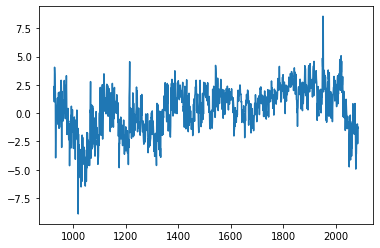

In [18]:
%time z = fracdiff(x, order=0.5)
plt.plot(z);

CPU times: user 1.5 ms, sys: 1.1 ms, total: 2.6 ms
Wall time: 1.78 ms


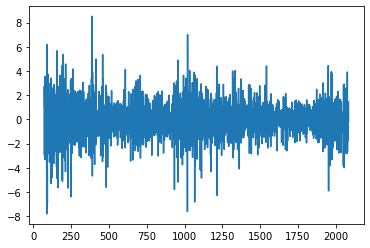

In [19]:
%time z = fracdiff(x, order=1.5)
plt.plot(z);

# Speed

In [20]:
%timeit z = firstdiff(x)
%timeit z, _ = intdiff(x, 1)
%timeit z = fracdiff(x, order=1)

13.4 µs ± 3.2 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)
60.5 µs ± 5.27 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
33.2 µs ± 4.31 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


# Memory

In [21]:
%memit z = firstdiff(x)
%memit z, _ = intdiff(x, 1)
%memit z = fracdiff(x, order=1)

peak memory: 84.36 MiB, increment: -0.33 MiB
peak memory: 83.92 MiB, increment: -0.38 MiB
peak memory: 83.82 MiB, increment: -0.04 MiB


# Line-by-Line

In [22]:
%mprun -f fracdiff fracdiff(x, order=1)

Filename: ../fracdiff/fracdiff_fn.py

Line #    Mem usage    Increment   Line Contents
     7     83.9 MiB     83.9 MiB   def fracdiff(X: np.ndarray, order: float = None, weights: list = None,
     8                                          truncation: int = None, tau: float = 1e-5, mmax: int = 20000,
     9                                          dtype=None) -> np.ndarray:
    10                                 # determine weights
    11     83.9 MiB      0.0 MiB       if weights is None:
    12     83.9 MiB      0.0 MiB           d = order if order else 0  # Default value, no differentiation
    13     83.9 MiB      0.0 MiB           if isinstance(truncation, int):
    14                                         weights = frac_weights(d, truncation)
    15                                     else:  # 'find' or None
    16     83.9 MiB      0.0 MiB               _, weights = find_truncation(d, tau=tau, mmax=mmax)
    17                             
    18                              

# References
* Jensen, A.N., Nielsen, M.Ø., 2014. A Fast Fractional Difference Algorithm. Journal of Time Series Analysis 35, 428–436. https://doi.org/10.1111/jtsa.12074
* Prado, M.L. de, 2018. Advances in Financial Machine Learning, 1st ed. Wiley.